### 1. Compare reanalysis data, model data and/or AWS data

In [176]:
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import scipy.stats as ss

In [177]:
# INPUTS
var = 'temp'      # Variable to compare
model = 'MERRA2'
start = pd.to_datetime('2004-04-01 00:00')
end = pd.to_datetime('2004-09-30 00:00')
res = 'd'
resample = True         # resample to res or just sample at that resolution
plothour = 12           # hour of day to plot if not resampling
timezone = pd.Timedelta(hours=-8)

# necessary initialization
units_checked = False
all_vars = {'temp':{'MERRA2':'T2M','ERA5':'t2m'},
            'tp':{'MERRA2':'PRECTOTCORR','ERA5':'tp'},
            'rh':{'MERRA2':'RH2M','ERA5':'rh'},
            'SWin':{'MERRA2':'SWGDN','ERA5':'ssrd'},
            'LWin':{'MERRA2':'LWGAB','ERA5':'strd'},
            'uwind':{'MERRA2':'U2M','ERA5':'u10'},
            'vwind':{'MERRA2':'V2M','ERA5':'v10'},
            'sp':{'MERRA2':'PS','ERA5':'sp'},
            'tcc':{'MERRA2':'CLDTOT','ERA5':'tcc'},
            'bcwet':{'MERRA2':'BCWT002'},'bcdry':{'MERRA2':'BCDP002'},
            'dustwet':{'MERRA2':'DUWT002'},'dustdry':{'MERRA2':'DUDP002'}}

In [178]:
# FILEPATHS
fp_clim = '/home/claire/research/climate_data/'
fp_MERRA2 = os.path.join(fp_clim,'MERRA2/VAR/MERRA2_VAR_LAT_LON.nc')
fp_ERA5 = os.path.join(fp_clim,'ERA5/ERA5_hourly/ERA5_VAR_hourly.nc')
fp_AWS = os.path.join(fp_clim,'AWS/Preprocessed/gulkana_20yrs.csv') # 'AWS/Preprocessed/south/south2280_2008.csv'
# 'AWS/Gulkana/LVL2/gulkana1480_hourly_LVL2.csv'
list_RGI = os.listdir('/home/claire/research/RGI/rgi60/00_rgi60_attribs/')

In [179]:
# GLACIER COORDINATES
# fill out glac_no for cenlat/lon and glacier_name for getting AWS data
glac_no = '01.00570' # '01.16195' 
glacier_name = 'Gulkana' # 'South'
# glac_no = '15.03733'
# glacier_name = 'Khumbu'
region = glac_no[:2]
for file in list_RGI:
    if region in file:
        fp_RGI = '/home/claire/research/RGI/rgi60/00_rgi60_attribs/' + file
# extract lat/lon of glacier
glacier_table = pd.read_csv(fp_RGI)
glacier_table = glacier_table.loc[glacier_table['RGIId'] == 'RGI60-'+glac_no]
cenlat = glacier_table['CenLat'].to_numpy()[0]
cenlon = glacier_table['CenLon'].to_numpy()[0]

In [180]:
# GET MODEL DATA
if model in ['MERRA2']:
    start_M = start + pd.Timedelta(minutes=30) - timezone
    end_M = end + pd.Timedelta(minutes=30) - timezone
    file_lat = str(int(np.floor(cenlat/10)*10))
    file_lon = str(int(np.floor(cenlon/10)*10))
    fn_MERRA2 = fp_MERRA2.replace('LAT',file_lat).replace('LON',file_lon)
    fn_MERRA2 = fn_MERRA2.replace('VAR',all_vars[var]['MERRA2'])
    ds = xr.open_dataset(fn_MERRA2)
    ds = ds.sel(time=pd.date_range(start_M,end_M,freq='h'))
    ds = ds.interp(time=pd.date_range(start-timezone,end-timezone,freq='h'))
    ds.coords['time'] = pd.date_range(start,end,freq='h')
    eds = xr.open_dataset('~/research/climate_data/MERRA2/MERRA2constants.nc4')
    latname = 'lat'
    lonname = 'lon'
    elevname = 'PHIS'

elif model in ['ERA5']:
    fn_ERA5 = fp_ERA5.replace('VAR',var)
    ds = xr.open_dataset(fn_ERA5)
    eds = xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_geopotential.nc')
    latname = 'latitude'
    lonname = 'longitude'
    elevname = 'z'

# get latitude and longitude of nearest point
datalat = ds.coords[latname][:].values
datalon = ds.coords[lonname][:].values
lat_nearidx = np.abs(cenlat - datalat).argmin()
lon_nearidx = np.abs(cenlon - datalon).argmin()
lat = datalat[lat_nearidx]
lon = datalon[lon_nearidx]

if model == 'ERA5':
    lat = lat.round(2)
    lon = lon.round(2)
    if var == 'tcc':
        lat = lat.round(1)
        lon = lon.round(1)

# select dataset by closest lat/lon to glacier center
ds = ds.sel({latname:lat,lonname:lon}).drop_vars([latname,lonname])
eds = eds.sel({latname:lat,lonname:lon})
elev = eds[elevname].to_numpy()[0] / 9.81
ds_model = ds.copy(deep=True)

In [181]:
# GET AWS DATA
df_AWS = pd.read_csv(fp_AWS,index_col=0)
df_AWS.index = pd.to_datetime(df_AWS.index)
if 'z' not in df_AWS.columns:
    AWS_elev = 1480 # FILL OUT MANUALLY
else:
    AWS_elev = df_AWS.iloc[0]['z']

if 'site_temp_USGS' in df_AWS.columns:
    df_AWS = df_AWS.rename(columns={'site_temp_USGS':'temp'})
if 'Precip_Weighing_Incremental' in df_AWS.columns:
    df_AWS.fillna({'Precip_Weighing_Incremental':df_AWS['Precip_Stage_Incremental']*1.48},inplace=True)
    df_AWS = df_AWS.rename(columns={'Precip_Weighing_Incremental':'tp'})

if start >= df_AWS.index[0] and end <= df_AWS.index[len(df_AWS)-1]:
    df_AWS = df_AWS.loc[pd.date_range(start,end,freq='h')]
else:
    start = pd.to_datetime(df_AWS.index[0])
    end = pd.to_datetime(df_AWS.index[len(df_AWS)-1])
df_AWS = df_AWS[var].to_frame()

In [182]:
# CHECK UNITS AND ADJUST TO ELEVATION
if not units_checked:
    if var == 'tp':
        df_AWS = df_AWS['tp'] / 1000
        ds_model = ds_model * 3600 / 1000
    elif var == 'temp':
        ds_model = ds_model - 273.15
        print(f'Adjusting to {AWS_elev - elev:.1f} m elevation change from geopotential to the AWS elevation')
        print(f'(temperature change of {-0.0065*(AWS_elev - elev) :.3f} C)')
        ds_model = ds_model - 0.0065*(AWS_elev - elev)
    elif var in ['SWin','LWin']:
        df_AWS /= 3600

Adjusting to 247.2 m elevation change from geopotential to the AWS elevation
(temperature change of -1.607 C)


Plot the mean over the period of each hour of day (good quality control check)

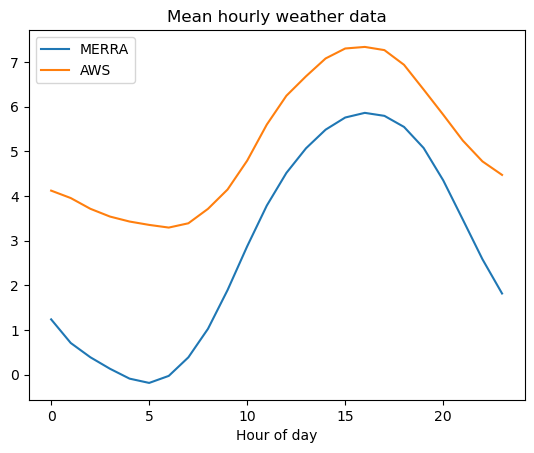

In [183]:
ds_model['hour'] = (['time'],pd.to_datetime(ds_model['time'].values).hour)
if isinstance(df_AWS,pd.DataFrame):
    df_AWS = df_AWS.assign(hour=pd.to_datetime(df_AWS.index).hour)
else:
    df_AWS = df_AWS.to_frame().assign(hour=pd.to_datetime(df_AWS.index).hour)
hourly_model = []
hourly_AWS = []
for hour in np.arange(24):
    ds_hour = ds_model.where(ds_model['hour'] == hour,drop=True)
    vardata = ds_hour[all_vars[var]['MERRA2']].values
    hourly_mean = np.mean(vardata[~np.isnan(vardata)])
    hourly_model.append(hourly_mean)

    df_hour = df_AWS.loc[df_AWS['hour'] == hour]
    vardata = df_hour[var].to_numpy()
    hourly_mean = np.mean(vardata[~np.isnan(vardata)])
    hourly_AWS.append(hourly_mean)
plt.plot(np.arange(24),hourly_model,label='MERRA')
plt.plot(np.arange(24),hourly_AWS,label='AWS')
plt.legend()
plt.ylabel('')
plt.xlabel('Hour of day')
plt.title('Mean hourly weather data')
plt.show()

In [184]:
# ds_model['Month'] = (['time'],np.array([pd.to_datetime(time).month for time in ds_model.time.values]))
# bias_df = pd.read_csv('/home/claire/research/PyGEM-EB/pygem_eb/sample_data/gulkana/Gulkana_MERRA2_temp_bias.csv',index_col=0)
# print(ds_model.T2M.mean())
# for month in bias_df.index:
#     bias = bias_df.loc[month,'bias']
#     indices = ds_model['Month'] == month
#     if len(indices) > 0:
#         ds_model['T2M'] = xr.where(indices,ds_model['T2M']+bias,ds_model['T2M'])
# print(ds_model.T2M.mean())

Resample or select the data with the proper resolution

In [185]:
# RESAMPLE
if resample:
    if var in ['tp']:
        df_AWS = df_AWS.resample(res).sum()
        ds_model = ds_model.resample(time=res).sum()
    if var in ['bcwet','bcdry','dustwet','dustdry']:
        ds_model = ds_model.resample(time=res).sum() * 3600
    else:
        df_AWS = df_AWS.resample(res).mean()
        ds_model = ds_model.resample(time=res).mean()
        if len(df_AWS.index) != len(ds_model.coords['time']):
            df_AWS = df_AWS.iloc[1:]
else:
    starthour = str((start+pd.Timedelta(days=1)).date()) + f' {plothour}:00'
    endhour = str((end-pd.Timedelta(days=1)).date()) + f' {plothour}:00'
    timehour = pd.date_range(starthour,endhour,freq='d')
    ds_model = ds_model.sel(time=timehour)
    df_AWS = df_AWS.loc[timehour]

Perform two-sided t-test to determine if the means are significantly different

In [186]:
plot_model = ds_model[all_vars[var][model]].values
df_AWS = df_AWS.fillna(0)
plot_AWS = df_AWS[var].to_numpy() #['Precip_Weighing_Incremental'].to_numpy()
if var == 'tp':
    plot_model = np.cumsum(plot_model)
    plot_AWS = np.cumsum(plot_AWS)
ttest = ss.ttest_rel(plot_AWS,plot_model,alternative='two-sided')
p = ttest.pvalue
print('Means:')
print('  ttest pvalue:', p)
if p < 0.05:
    result = 'significantly different'
else:
    result = 'not different'
print('     ',result)

Means:
  ttest pvalue: 2.3140495855074755e-35
      significantly different


Plot comparison

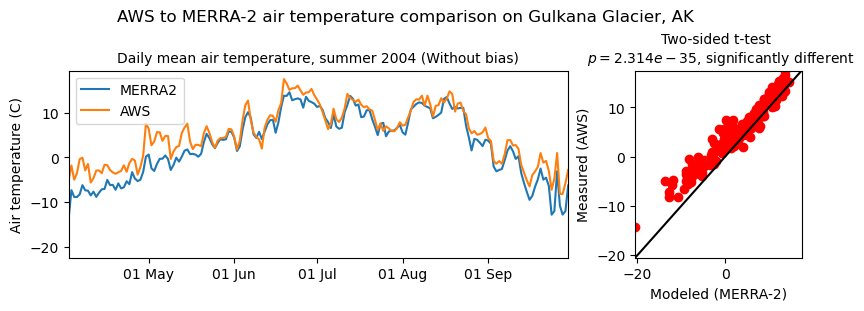

In [187]:
fig,[ax1,ax2] = plt.subplots(1,2,width_ratios=[3,1],figsize=(8,3),layout='constrained')
ax1.plot(ds_model['time'],plot_model,label=model)
ax1.plot(df_AWS.index,plot_AWS,label='AWS')
ax1.legend()
ax2.scatter(plot_model,plot_AWS,label='AWS',c='r')
maxval = max(np.max(plot_AWS),np.max(plot_model))
minval = min(np.min(plot_AWS),np.min(plot_model))
ax2.plot([minval,maxval],[minval,maxval],c='black')
ax1.set_ylabel('Air temperature (C)')
ax2.set_ylabel('Measured (AWS)')
ax2.set_xlabel('Modeled (MERRA-2)')
date_form = mpl.dates.DateFormatter('%d %b')
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim([start+pd.Timedelta(days=1),end])
ax2.set_xlim([minval,maxval])
ax2.set_ylim([minval,maxval])
ax1.set_title('Daily mean air temperature, summer 2004 (Without bias)',fontsize=10)
ax2.set_title(f'Two-sided t-test \n $p={p:.3e}$, {result}',fontsize=10)
fig.suptitle('AWS to MERRA-2 air temperature comparison on Gulkana Glacier, AK')
plt.show()

### 3. Temperature bias in MERRA-2

In [52]:
def monthly_means(df):
    df['Date'] = pd.to_datetime(df.index)
    df['Month'] = df['Date'].dt.month
    df_monthly = df.groupby('Month').mean()
    return df_monthly

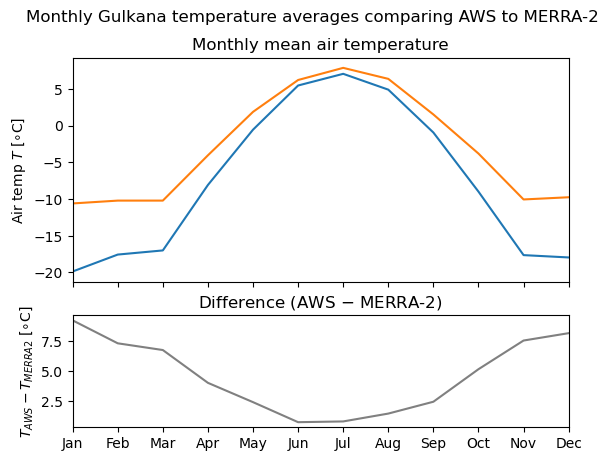

In [57]:
fig,ax = plt.subplots(2,height_ratios=[2,1],sharex=True)
date_range = pd.date_range('2024-01-01','2024-12-31',freq='MS')
monthnames = [date.strftime('%B')[:3] for date in date_range]
df_model = ds_model.to_dataframe().rename(columns={'T2M':'temp'})
monthly_model = monthly_means(df_model)
# df_AWS = df_AWS.to_frame().rename(columns={'site_temp_USGS':'temp'})
monthly_AWS = monthly_means(df_AWS)
diff = df_AWS['temp'] - df_model['temp']
monthly_diff = monthly_means(diff.to_frame())

ax[0].plot(monthnames,monthly_model['temp'],label='MERRA2')
ax[0].plot(monthnames,monthly_AWS['temp'],label='AWS')
ax[0].set_ylabel('Air temp $T$ [$\circ$C]')
ax[0].set_title('Monthly mean air temperature')
ax[1].plot(monthnames,monthly_diff['temp'],color='gray')
ax[1].set_ylabel('$T_{AWS}-T_{MERRA2}$ [$\circ$C]')
ax[1].set_title('Difference (AWS $-$ MERRA-2)')
ax[1].set_xlim(monthnames[0],monthnames[11])
fig.suptitle('Monthly Gulkana temperature averages comparing AWS to MERRA-2')
plt.show()

In [137]:
# monthly_diff['diff'] = monthly_diff['temp']
# monthly_diff['diff'].to_csv('/home/claire/research/PyGEM-EB/pygem_eb/data/Gulkana_MERRA2_temp_diff.csv')

In [26]:
df = pd.read_csv('/home/claire/research/PyGEM-EB/pygem_eb/sample_data/gulkana/Gulkana_MERRA2_temp_bias.csv',index_col=0)
df

,bias
Month,
1,9.105425
2,7.270101
3,6.876635
4,4.119061
5,2.497643
6,0.789153
7,1.081381
8,1.419114
9,2.389362


In [376]:
df=pd.read_csv('/home/claire/research/climate_data/AWS/Gulkana/LVL2/gulkana1480_hourly_LVL2.csv')
df.index = pd.to_datetime(df['local_time'])
all_temps = []
yearly_avgs = []
for year in np.arange(2000,2019):
    all_dates = []
    for day in np.arange(18,23):
        start = pd.to_datetime(f'{year}/06/{day} 10:00')
        end = pd.to_datetime(f'{year}/06/{day+1} 20:00')
        dates = pd.date_range(start,end,freq='h')
        all_dates.append(dates)
    all_dates = np.array(all_dates).ravel()
    all_temps.append(df['site_temp_USGS'].loc[all_dates])
    yearly_avgs.append(np.max(df['site_temp_USGS'].loc[all_dates]))
all_temps = np.array(all_temps).ravel()
all_temps = all_temps[~np.isnan(all_temps)]
print(np.mean(all_temps))

8.061015873015874


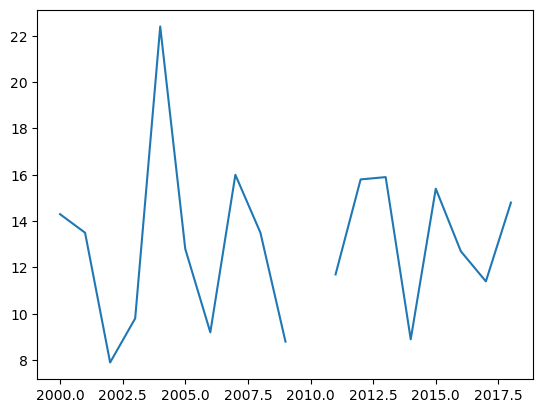

In [377]:
plt.plot(np.arange(2000,2019),yearly_avgs)